# New Style HDMI input and Pixel Formatting

This notebook introduces the new features of PYNQ 1.5 for interacting the video pipeline. The API has been completely
redesigned with high performance image processing applications in mind.

To start with download the base overlay and instantate the HDMI input and output.

In [1]:
from pynq import Overlay
from pynq.lib.video import *

base = Overlay('base.bit')
hdmi_in = base.video.hdmi_in
hdmi_out = base.video.hdmi_out

## Getting started

First we'll use the default pixel format which is 24 bit-per-pixel BGR formatted data for ease of use with OpenCV. 

In [2]:
hdmi_in.configure()
hdmi_out.configure(hdmi_in.mode)

hdmi_in.start()
hdmi_out.start()

The monitor should turn on and show a blank screen. To pass the image data through we can tie the output to the input. The tie will last until we send something else to be displayed.

In [3]:
hdmi_in.tie(hdmi_out)

While this provides for a fast way of passing video data through the pipeline there is no way to access or modify the frames. For that we a loop calling `readframe` and `writeframe`.

In [4]:
import time

numframes = 600
start = time.time()

for _ in range(numframes):
    f = hdmi_in.readframe()
    hdmi_out.writeframe(f)
    
end = time.time()
print("Frames per second:  " + str(numframes / (end - start)))

Frames per second:  60.02182752931844


Next we can start adding some OpenCV processing into the mix. For all of these examples we are going to use a lapcian gradient filter. The first loop is going to perform the grayscale conversion in software.

In [5]:
import cv2
import numpy as np

numframes = 10
grayscale = np.ndarray(shape=(hdmi_in.mode.height, hdmi_in.mode.width),dtype=np.uint8)
result = np.ndarray(shape=(hdmi_in.mode.height, hdmi_in.mode.width),dtype=np.uint8)

start = time.time()

for _ in range(numframes):
    inframe = hdmi_in.readframe()
    cv2.cvtColor(inframe,cv2.COLOR_BGR2GRAY,dst=grayscale)
    inframe.freebuffer()
    cv2.Laplacian(grayscale, cv2.CV_8U, dst=result)

    outframe = hdmi_out.newframe()
    cv2.cvtColor(result, cv2.COLOR_GRAY2BGR,dst=outframe)
    hdmi_out.writeframe(outframe)
    
end = time.time()
print("Frames per second:  " + str(numframes / (end - start)))

Frames per second:  3.4786875334086136


Using the new infrastructure we can delegate the color conversion to the hardware as well as only passing a single grayscale pixel to and from the processor.

First reconfigure the pipelines in grayscale mode and tie the two together to make sure everything is working correctly.

In [6]:
hdmi_in.configure(PIXEL_GRAY)
hdmi_out.configure(hdmi_in.mode)

hdmi_in.start()
hdmi_out.start()

hdmi_in.tie(hdmi_out)

No we can rewrite the loop without the software colour conversion.

In [7]:
start = time.time()

numframes = 30

for _ in range(numframes):
    inframe = hdmi_in.readframe()
    outframe = hdmi_out.newframe()
    cv2.Laplacian(inframe, cv2.CV_8U, dst=outframe)
    inframe.freebuffer()
    hdmi_out.writeframe(outframe)
    
end = time.time()
print("Frames per second:  " + str(numframes / (end - start)))

Frames per second:  7.891744304692827


## Other modes

There are two other 24 bit modes that are useful for interacting with PIL. The first is regular RGB mode.

In [8]:
hdmi_in.configure(PIXEL_RGB)
hdmi_out.configure(hdmi_in.mode, PIXEL_RGB)

hdmi_in.start()
hdmi_out.start()

hdmi_in.tie(hdmi_out)

This is useful for easily creating and displaying frames with Pillow

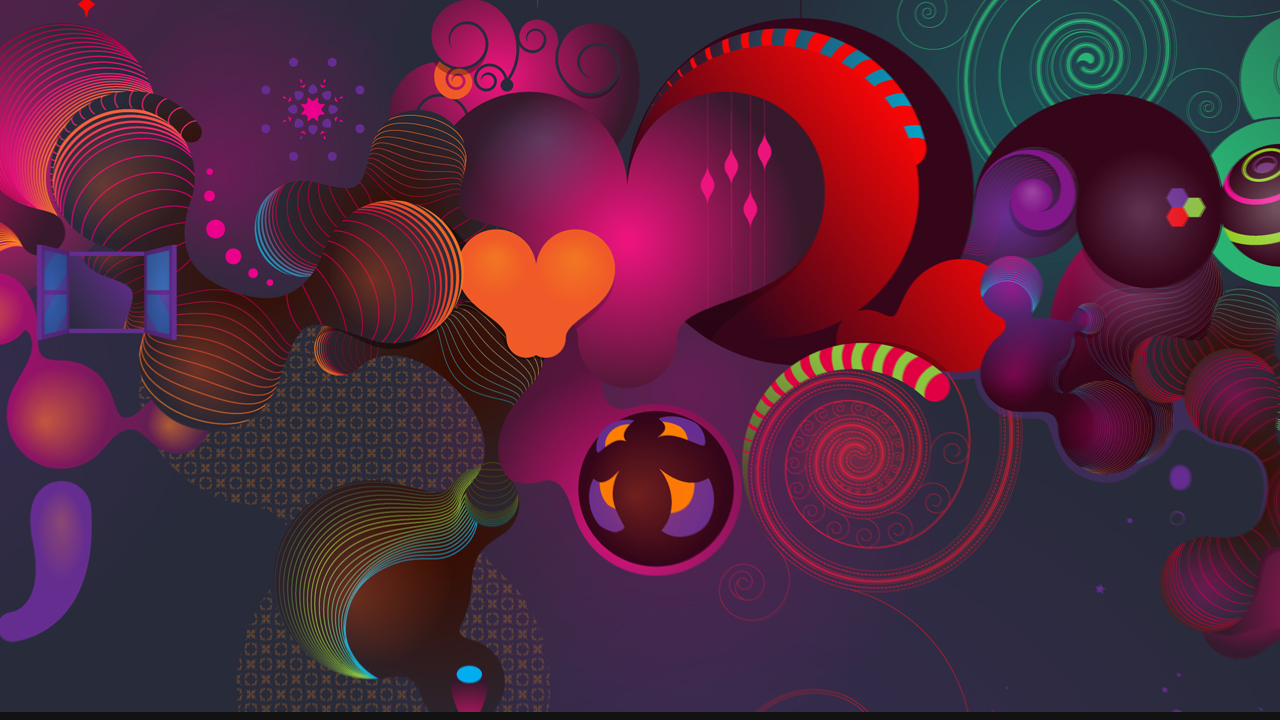

In [9]:
import PIL.Image

frame = hdmi_in.readframe()
image = PIL.Image.fromarray(frame)
image

An alternative mode is YCbCr which is useful for some image processing algorithms or exporting JPEG files. Because we are not changing the number of bits per pixel we can update the colorspace of the input dynamically.

In [10]:
hdmi_in.colorspace = COLOR_IN_YCBCR

It's probably worth updating the output colorspace as well to avoid the psychedelic  effects

In [11]:
hdmi_out.colorspace = COLOR_OUT_YCBCR

Now we can use PIL to read in the frame an perform the conversion back for us.

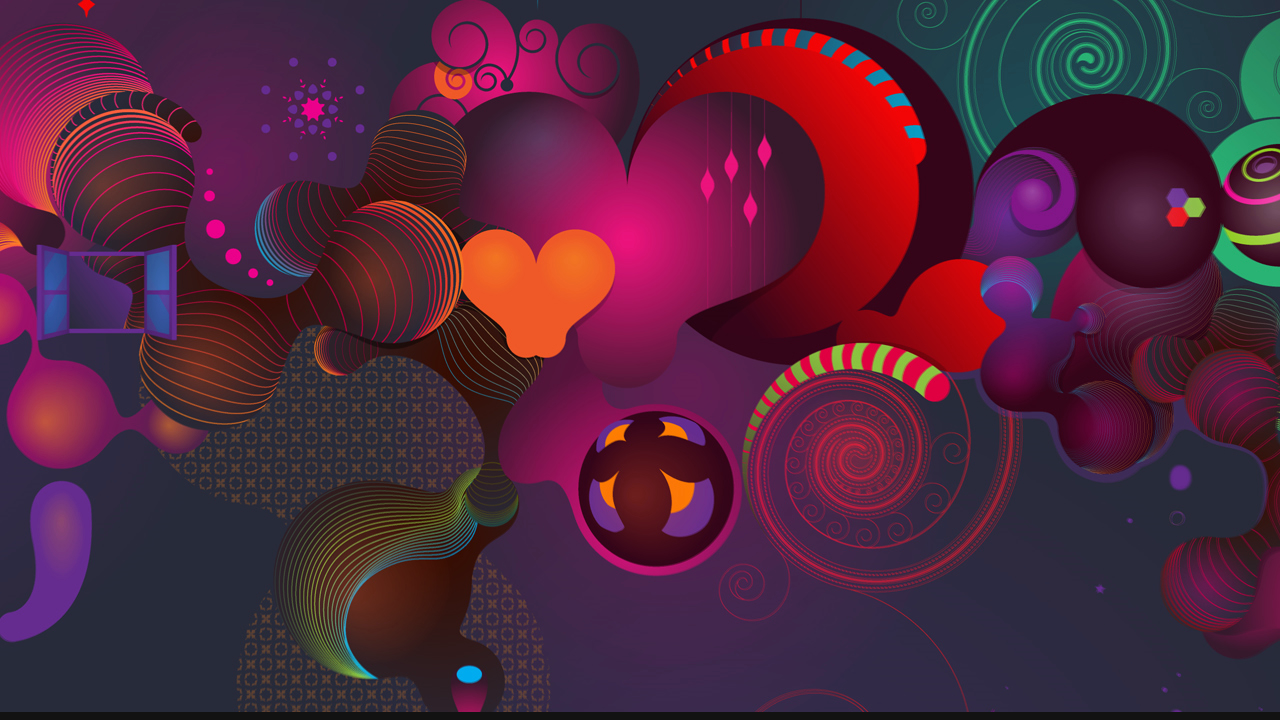

In [12]:
import PIL.Image

frame = hdmi_in.readframe()
image = PIL.Image.fromarray(frame, "YCbCr")
frame.freebuffer()
image.convert("RGB")

## Cleaning up

Finally you must always stop the interfaces when you are done with them. Otherwise bad things can happen when the bitstream is reprogrammed. You can also use the HDMI interfaces in a context manager to ensure that the cleanup is always performed.

In [13]:
hdmi_out.close()
hdmi_in.close()

## Performing cleanup automatically using `with` blocks

The `configure()` and `start()` can be used with `with` to automatically call `close()` and `stop()` at the end of the block. This helps mitigate problems with the HDMI device not being cleaned up. For example to grap a single frame from the HDMI input we can do:

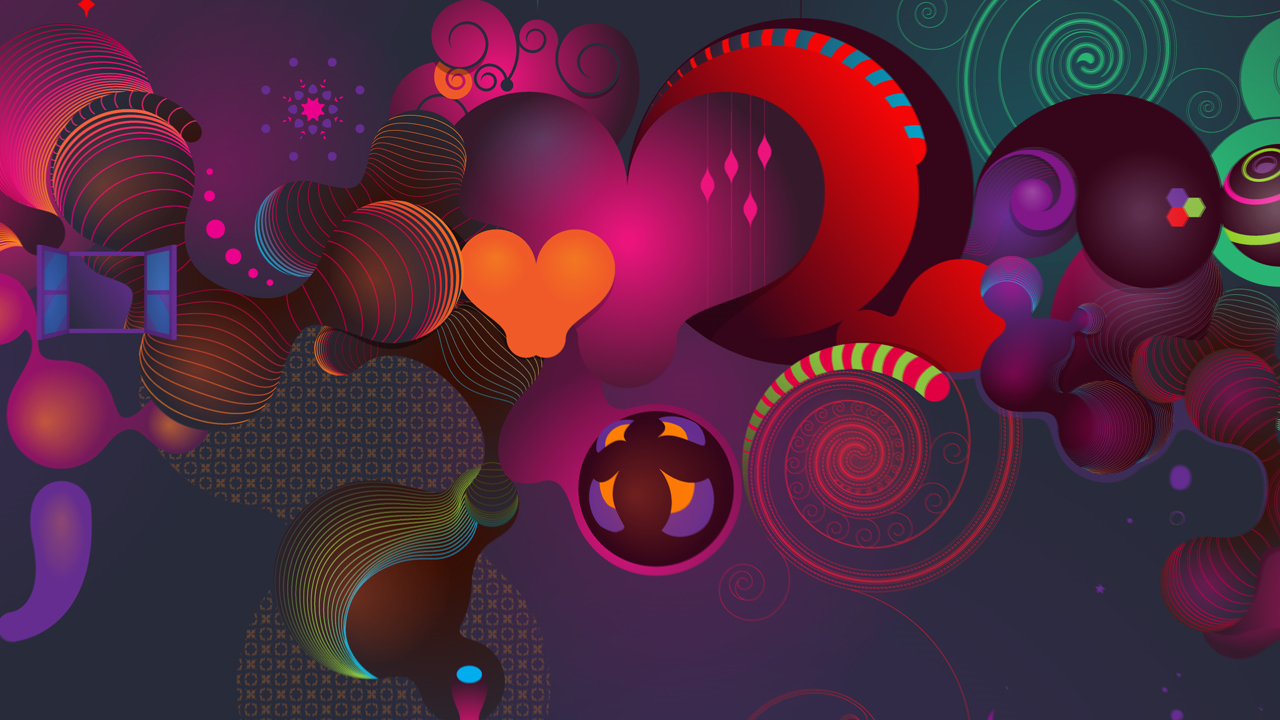

In [14]:
with hdmi_in.configure(PIXEL_RGB):
    hdmi_in.start()
    frame = hdmi_in.readframe()
    image = PIL.Image.fromarray(frame)

image

## Next Steps

This notebook has only provided an overview of base overlay pipeline. One of the reasons for the changes was to make it easier to add hardware accelerated functions by supporting a wider range of pixel formats without software conversion and separating out the HDMI front end from the video DMA. Explore the code in pynq/lib/video.py for more details.